# Notebook

## Imports

In [73]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMRegressor
import numpy as np
from scipy import stats
%matplotlib inline

raw_dataset = pd.read_csv("data/raw_dataset.csv")

## Visualisation des données

### Colonnes

- `crim` : Taux de criminalité par habitant dans la zone résidentielle
- `zn` : Pourcentage de terrains résidentiels de plus de 25 000 pieds carrés
- `indus` : Pourcentage de surface occupée par des entreprises non commerciales (industrie légère)
- `chas` : Indicateur binaire signalant si la zone est adjacente à la Charles River (1 = oui, 0 = non)
- `nox` : Concentration moyenne en oxydes d’azote (polluants atmosphériques), mesurée en parties par 10 millions
- `rm` : Nombre moyen de pièces par logement dans la zone considérée. Variable continue, souvent corrélée à la taille ou au standing du logement.
- `age` : Proportion (%) de logements construits avant 1940.
- `dis` : Distance pondérée aux cinq principaux centres d'emplois de Boston.
- `rad` : Indice d’accessibilité aux autoroutes radiales. Valeur entière reflétant une cotation d’accessibilité.
- `tax` : Taux d’imposition foncière à valeur pleine par tranche de 10 000 dollars.
- `ptratio` : Ratio moyen d’élèves par enseignant dans les écoles publiques de la zone.
- `b` : Variable calculée à partir de la proportion de résidents issus d’un groupe démographique particulier. Formule : 1000(Bk - 0.63)^2, où Bk est la proportion de population noire.
- `lstat` : Pourcentage de la population ayant un statut socio-économique faible
- `medv` : Valeur médiane des logements occupés par leurs propriétaires, exprimée en milliers de dollars. Il s’agit de la variable cible dans le cadre d’une tâche de prédiction de prix.

Pour simplifier le travail de nettoyage, nous allons renommer les colonnes afin de les rendre plus explicites.

In [74]:
raw_dataset = raw_dataset.rename(columns={
    "crim": "taux_criminalite",
    "zn": "taux_grands_terrains",
    "indus": "taux_industrie",
    "chas": "charles_river_adj",
    "nox": "pollution_atm",
    "rm": "nb_pieces",
    "age": "taux_vieux_logements",
    "dis": "dist_emplois",
    "rad": "autoroute_access",
    "tax": "taux_foncier",
    "ptratio": "eleve_prof_ratio",
    "b": "taux_pop_noire",
    "lstat": "taux_pop_pauvre",
    "medv": "val_logements"
})

### Analyse statistique

In [75]:
raw_dataset.describe()

,taux_criminalite,taux_grands_terrains,taux_industrie,charles_river_adj,pollution_atm,nb_pieces,taux_vieux_logements,dist_emplois,autoroute_access,taux_foncier,eleve_prof_ratio,taux_pop_noire,taux_pop_pauvre,val_logements
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Corrélations

<Axes: >

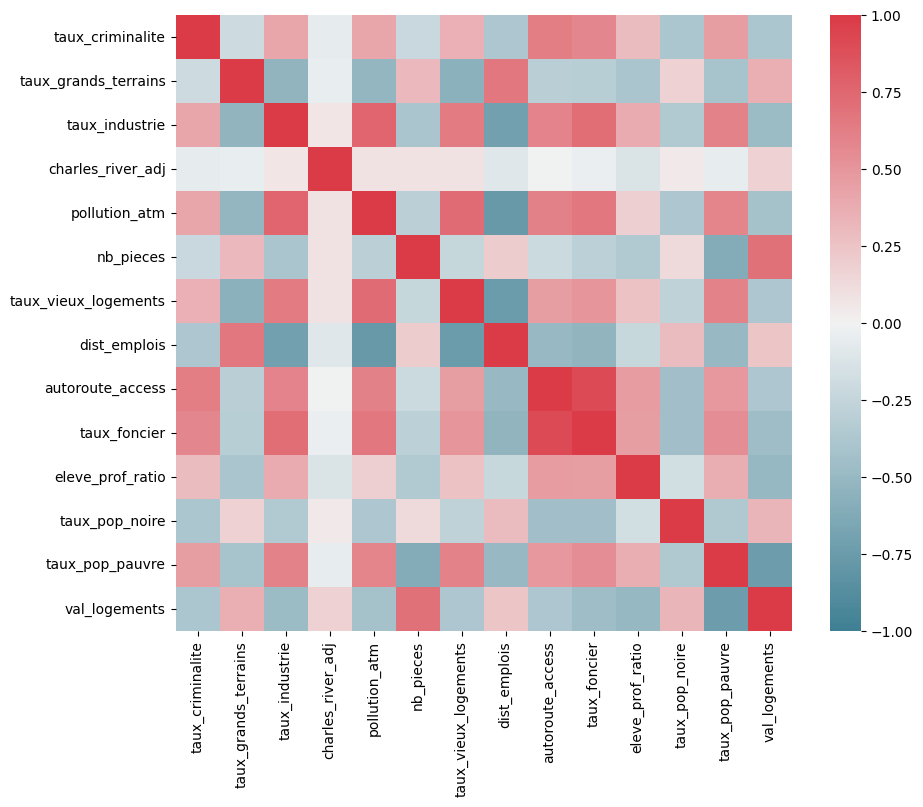

In [76]:
f, ax = plt.subplots(figsize=(10, 8))
corr = raw_dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax
)

La valeur des logements dans une zone d'habitation est positivement impactée par la présence de grands terrains, le nombre de pièces dans un logement, la proximiité avec la Charles River, des emplois accessibles et la présence de populations noires.

En revanche, la valeur des logements est négativement impactée par un taux de criminalité élevé, la proportion de terrains
dédiés à l'industrie, la pollution atmosphérique, la proportion de vieux logements, le manque d'autoroutes accessibles,une
taxe foncière élevée, un manque de professeurs, et la présence de populations avec un statut socio-économique faible.

### Valeurs aberrantes

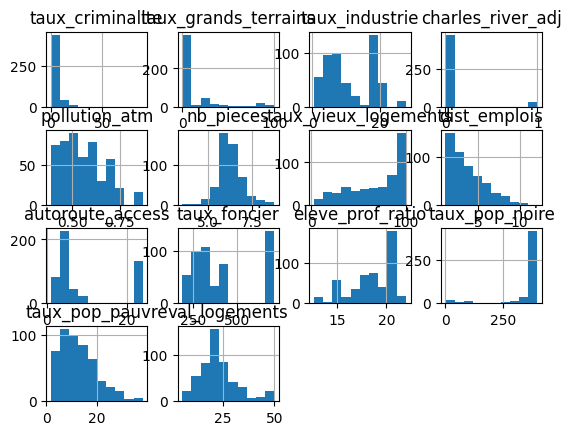

In [77]:
raw_dataset.hist()
plt.show()

Les colonnes `nb_pieces` et `val_logements` semblent suivre une loi normale.
Nous allons donc vérifier que ces colonnes ne contiennent pas de valeurs aberrantes.

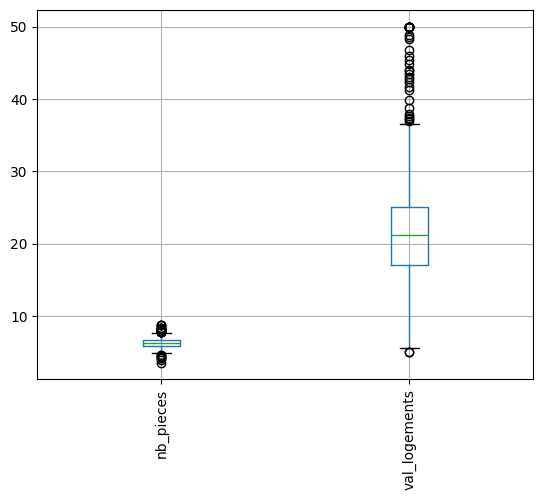

In [78]:
ax = raw_dataset.boxplot(column=["nb_pieces", "val_logements"])
ax.set_xticks(ax.get_xticks())  # Ensure rotation is applied to all ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Nous avons détecté des valeurs aberrantes dans les colonnes `nb_pieces` et `val_logements`

### Données manquantes

<Axes: >

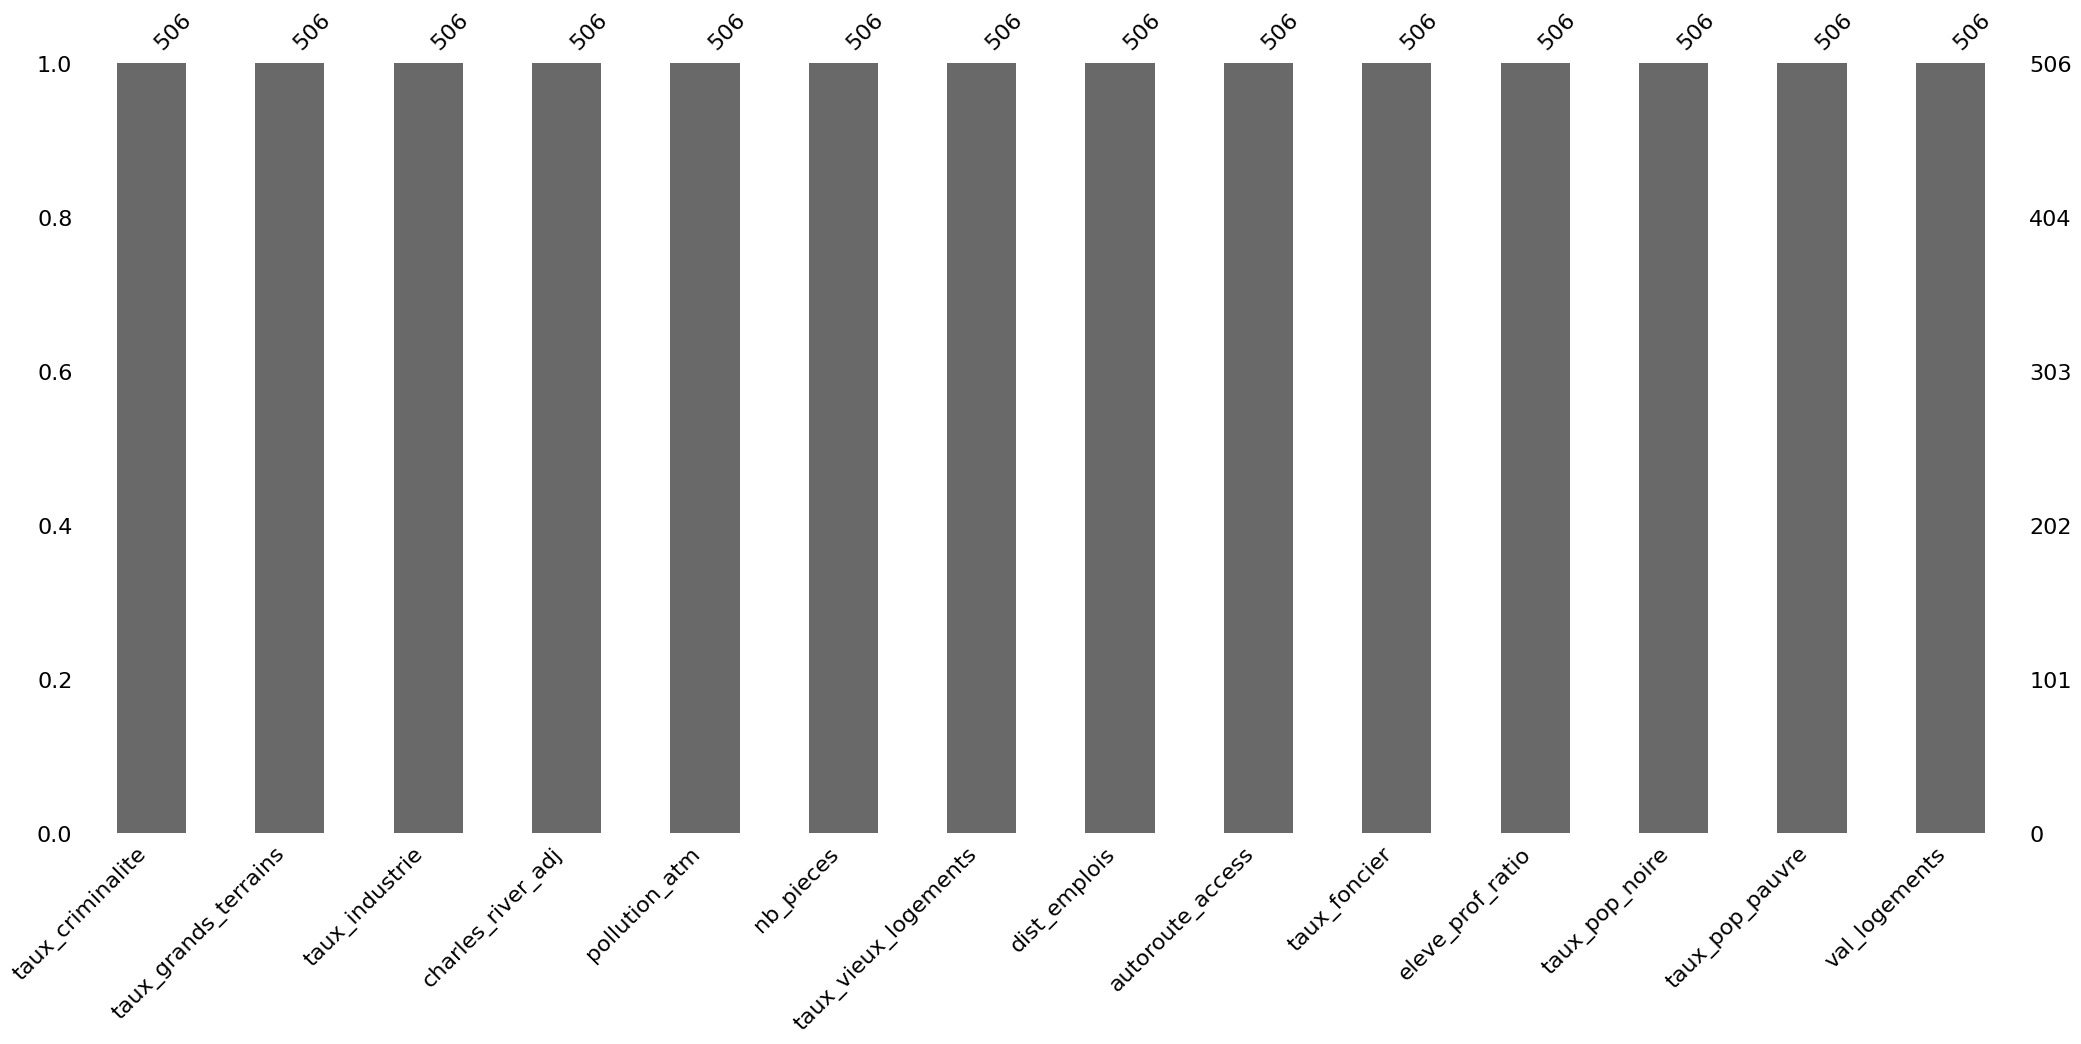

In [79]:
msno.bar(raw_dataset)

Il n'y a pas de lignes ayant des valeurs indéfinies.

## Nettoyage du jeu de données

### Suppression des doublons

In [80]:
cleaned_dataset = raw_dataset.drop_duplicates(inplace=False)

### Suppression des valeurs aberrantes

In [81]:
threshold = 1.5

def find_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cleaned_dataset[(col < Q1 - threshold * IQR) | (col > Q3 + threshold * IQR)]
    return outliers

nb_pieces_outliers = find_outliers(cleaned_dataset["nb_pieces"])
cleaned_dataset = cleaned_dataset.drop(nb_pieces_outliers.index)

val_logements_outliers = find_outliers(cleaned_dataset["val_logements"])
cleaned_dataset = cleaned_dataset.drop(val_logements_outliers.index)

## Analyse statistique du dataset nettoyé

In [82]:
cleaned_dataset.describe()

,taux_criminalite,taux_grands_terrains,taux_industrie,charles_river_adj,pollution_atm,nb_pieces,taux_vieux_logements,dist_emplois,autoroute_access,taux_foncier,eleve_prof_ratio,taux_pop_noire,taux_pop_pauvre,val_logements
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,3.316761,10.740618,11.322892,0.059603,0.554893,6.201737,68.216998,3.876200,9.434879,409.350993,18.607506,355.577064,13.120110,20.678587
std,7.898953,22.369596,6.779228,0.237011,0.117391,0.500305,28.069843,2.120276,8.665531,166.430293,2.057285,93.204849,6.616595,6.267863
min,0.006320,0.000000,0.740000,0.000000,0.385000,4.880000,2.900000,1.174200,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082440,0.000000,5.640000,0.000000,0.449000,5.884000,44.400000,2.122400,4.000000,284.000000,17.400000,375.210000,7.790000,16.600000
50%,0.229690,0.000000,9.900000,0.000000,0.538000,6.167000,76.700000,3.331700,5.000000,330.000000,19.100000,392.040000,12.120000,20.600000
75%,3.568680,12.500000,18.100000,0.000000,0.624000,6.495000,93.900000,5.287300,24.000000,666.000000,20.200000,396.330000,17.150000,24.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,7.691000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.770000,36.100000


<Axes: >

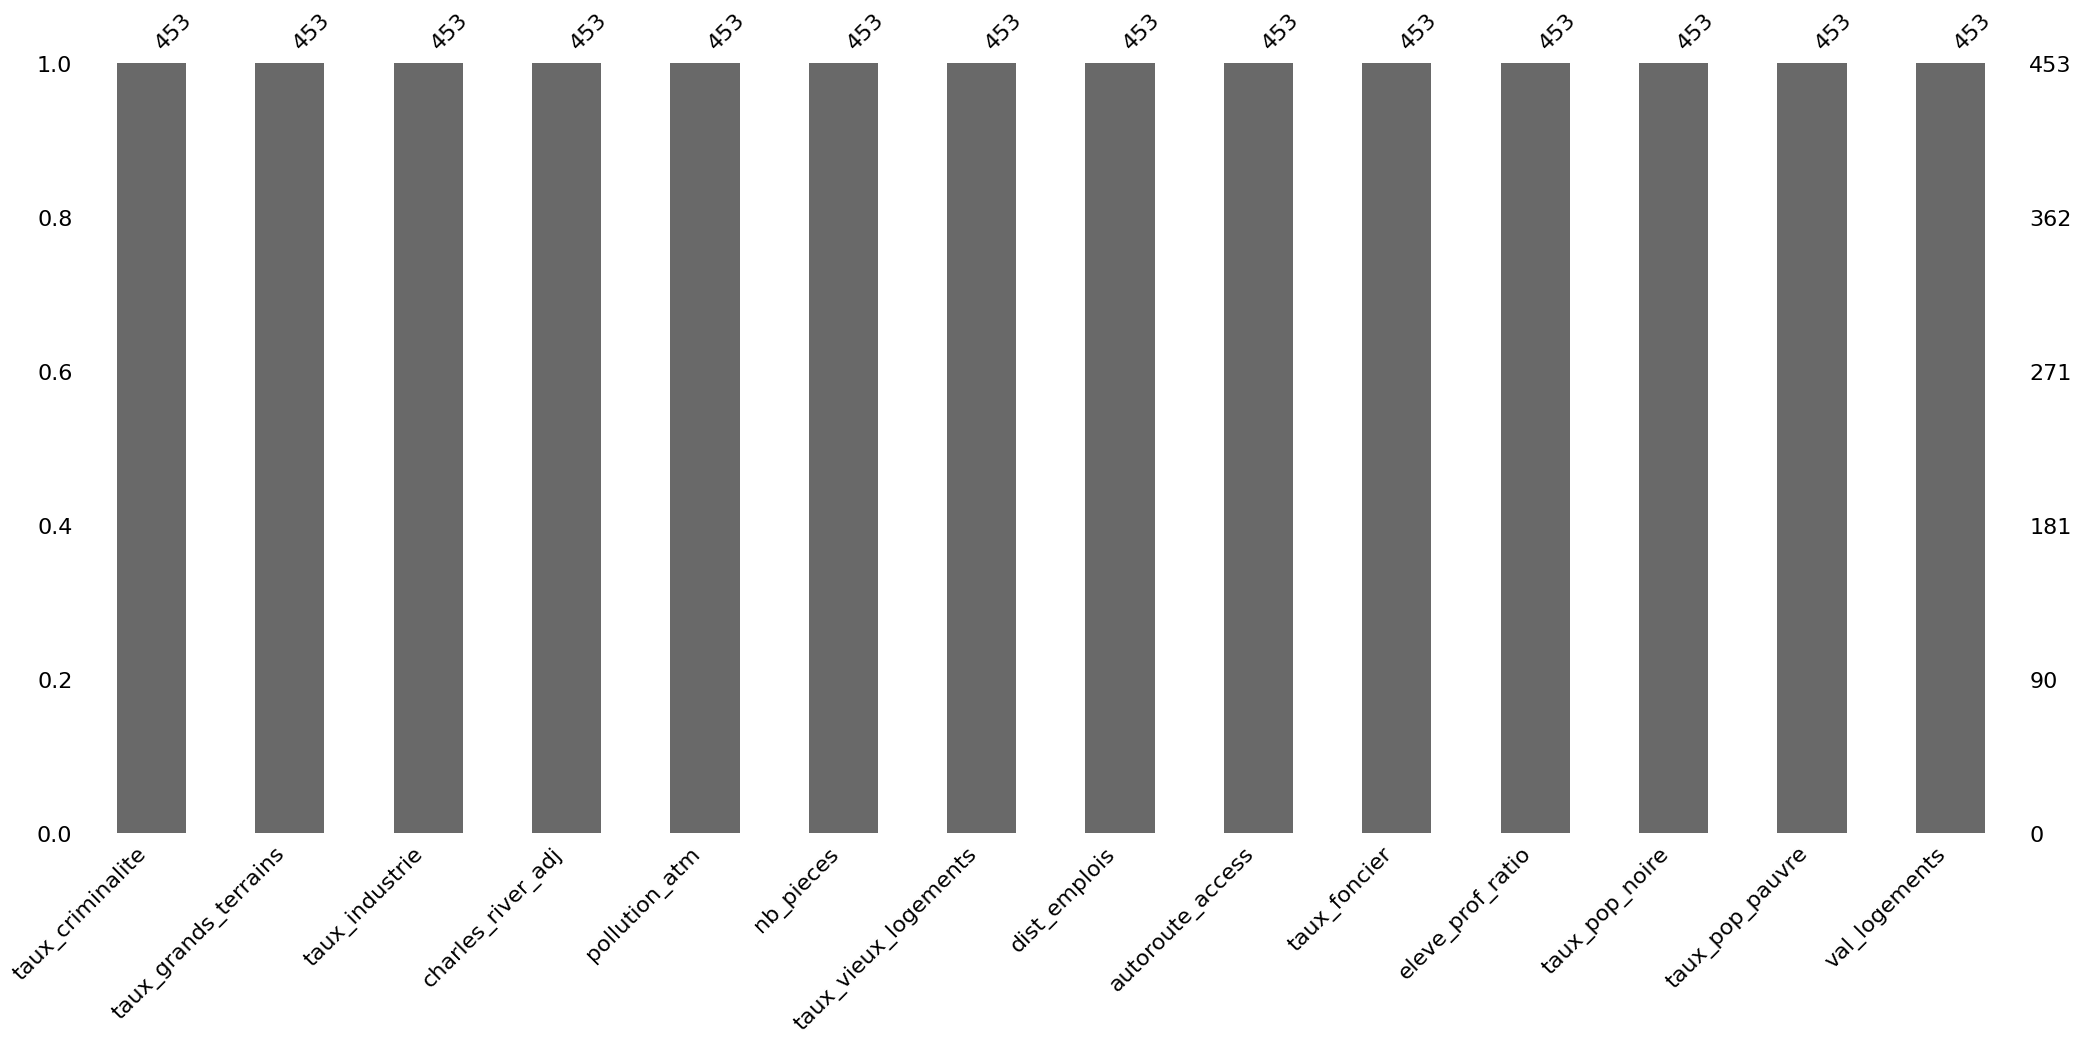

In [83]:
msno.bar(cleaned_dataset)

## Sauvegarde du dataset nettoyé

In [84]:
cleaned_dataset.to_csv('data/cleaned_dataset.csv')

## Mise en conformité

Notre jeu de données contient une colonne représentant la proportion de personnes noires dans une zone d'habitation.
Il s'agit d'une métrique qui risque de créer des biais racistes chez notre modèle. Nous allons donc la supprimer.

Nous supprimerons également la colonne `taux_pop_pauvre` afin de limiter d'autres comportements discriminatoires.

In [85]:
final_dataset = cleaned_dataset.copy()

final_dataset = final_dataset.drop(columns=["taux_pop_noire", "taux_pop_pauvre"])

<Axes: >

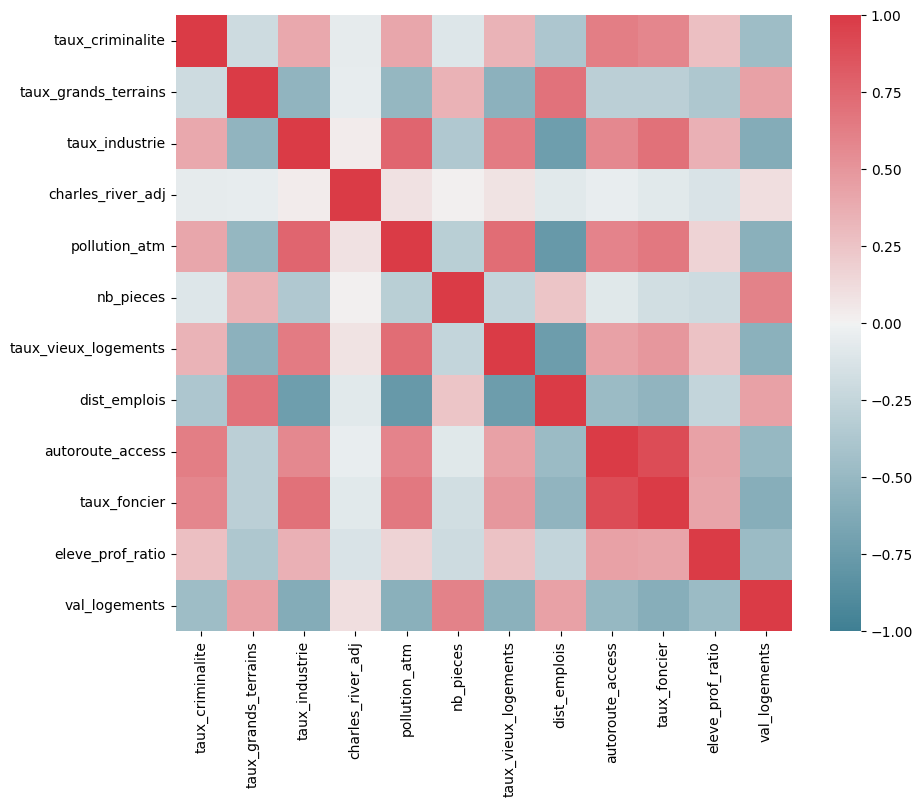

In [86]:
f, ax = plt.subplots(figsize=(10, 8))
corr = final_dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax
)

### Sauvegarde du jeu de données conforme

In [87]:
final_dataset.to_csv('data/final_dataset.csv')

## Preprocessing

### Standardisation

In [88]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

# Prétraitement
X = final_dataset.drop(columns=["val_logements"])

numerical_cols = X.select_dtypes(include="number").columns

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_cols),
])

X_processed = preprocessor.fit_transform(X)
y = final_dataset["val_logements"]

### Train-test split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entraînement du modèle

In [90]:
def evaluate_performance(y_true: list, y_pred: list):
    """
    Fonction pour mesurer les performances du modèle avec MSE, MAE et R².
    Entrées :
        - y_true : Sorties attendues (list)
        - y_pred : Sorties prédites par le modèle (list)
    Sortie :
        - MSE : Erreur quadratique moyenne (int)
        - MAE : Erreur absolue moyenne, écart entre les prédictions et les résultats attendus (int)
        - R² : Coefficient de détermination, mesure de la qualité des prédictions du modèle entre 0 et 1 (float)
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'MAE': mae, 'R²': r2}

### Régression linéaire

On cherche une relation linéaire entre nos variables d'entrée et la valeur des logements.

In [91]:
model_linear_regression = LinearRegression().fit(X_train, y_train)

y_linear_regression = model_linear_regression.predict(X_test)
evaluate_performance(y_test, y_linear_regression)

{'MSE': 9.415719602692574, 'MAE': 2.3760080407268904, 'R²': 0.7321085703877919}

### Random Forest

On cherche à créer un arbre de décision qui permettra de trouver la valeur des logements à partir de nos variables.

In [143]:
label_encoder = preprocessing.LabelEncoder()

model_random_forest = RandomForestRegressor(max_depth=10, random_state=0)
model_random_forest.fit(X_train, y_train)

y_random_forest = model_random_forest.predict(X_test)
evaluate_performance(y_test, y_random_forest)

{'MSE': 7.6873664609577395, 'MAE': 2.025838447577863, 'R²': 0.7812828250970858}

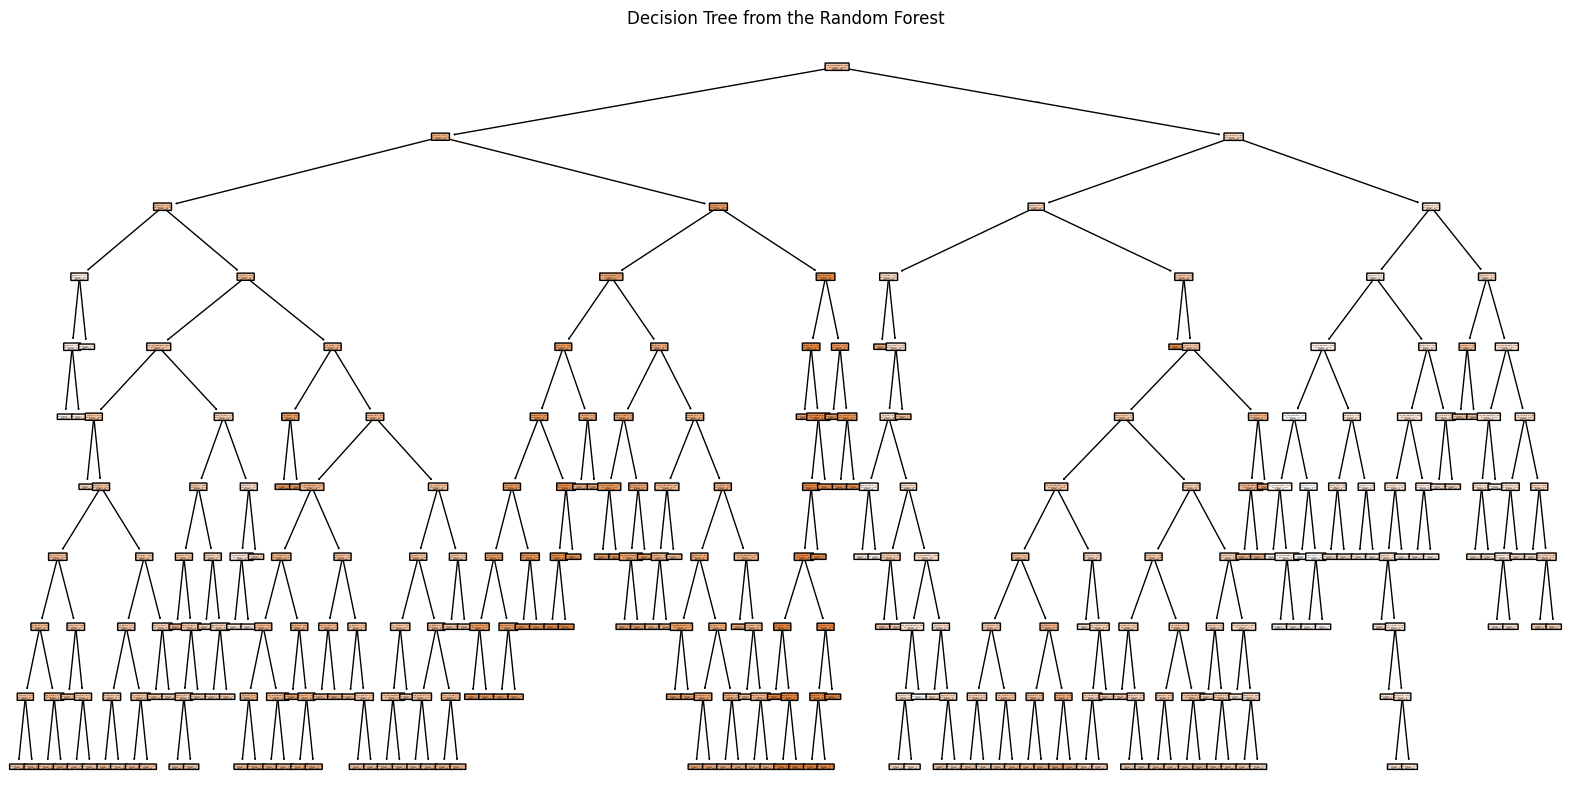

In [144]:
from sklearn.tree import plot_tree

tree = model_random_forest.estimators_[0]
plt.figure(figsize=(20,10))  # Set figure size to make the tree more readable
plot_tree(tree,
          feature_names=X_train.columns,  # Use the feature names from the dataset
          filled=True,              # Fill nodes with colors for better visualization
          rounded=True)             # Rounded edges for nodes
plt.title("Decision Tree from the Random Forest")
plt.show()

### LightGBM

Nous cherchons à nouveau à générer un arbre de décisions, cette fois-ci en utilisant le framework LightGBM.

In [103]:
model_lgbm = LGBMRegressor(
    objective='regression',
    metric='mse',
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model_lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='mse'
)

y_lgbm = model_lgbm.predict(X_test)
evaluate_performance(y_test, y_lgbm)

{'MSE': 7.41632616280957, 'MAE': 1.8999437084514137, 'R²': 0.788994330538759}

## Cross-validation

### Régression linéaire

In [145]:
np.mean(cross_val_score(model_linear_regression, X_train, y_train, cv=5, scoring='neg_root_mean_squared_log_error'))

-0.191552549670417

### Random forest

In [146]:
np.mean(cross_val_score(model_random_forest, X_train, y_train, cv=5, scoring='neg_root_mean_squared_log_error'))

-0.15295239030355717

### LightGBM

In [147]:
np.mean(cross_val_score(model_lgbm, X_train, y_train, cv=5, scoring='neg_root_mean_squared_log_error'))

-0.15478208160199558

Le modèle ayant le -RMSLE moyen le plus élevé est le modèle Random Forest. Il semblerait donc que ce soit le modèle le plus adapté à notre situation.